In [26]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use("default")
font = {'size'   : 16}
plt.rc('font', **font)

In [27]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [28]:
ncores = (32, 64, 128, 256, 512, 1024, 2048)
mlevels = (4, 4, 4, 4, 4, 4, 4)
thetaf = np.zeros(len(ncores))
thetarf = np.zeros(len(ncores))
deltar = np.zeros(len(ncores))
deltaf = np.zeros(len(ncores))
deltarf = np.zeros(len(ncores))
ranks = (4, 8, 9, 16, 32)
rank = 8
bad_pts = []
tol = 1e-8

serial = parseTiming("ks_ml1")

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetaf[i] = parseTol(f"ks_theta_fmg_nc{nc}", tol)
    if np.isnan(thetaf[i]):
        thetaf[i] = parseTiming(f"ks_theta_fmg_nc{nc}")
        bad_pts.append((nc, thetaf[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetarf[i] = parseTol(f"ks_theta_rfmg_nc{nc}", tol)
    if np.isnan(thetaf[i]):
        thetarf[i] = parseTiming(f"ks_theta_rfmg_nc{nc}")
        bad_pts.append((nc, thetarf[i]))


for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltar[i] = parseTol(f"ks_Delta{rank}_rf_nc{nc}", tol)
    if np.isnan(deltar[i]):
        deltar[i] = parseTiming(f"ks_Delta{rank}_rf_nc{nc}")
        bad_pts.append((nc, deltar[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltaf[i] = parseTol(f"ks_Delta{rank}_fmg_nc{nc}", tol)
    if np.isnan(deltaf[i]):
        deltaf[i] = parseTiming(f"ks_Delta{rank}_fmg_nc{nc}")
        bad_pts.append((nc, deltaf[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltarf[i] = parseTol(f"ks_Delta{rank}_rfmg_nc{nc}", tol)
    if np.isnan(deltarf[i]):
        deltarf[i] = parseTiming(f"ks_Delta{rank}_rfmg_nc{nc}")
        bad_pts.append((nc, deltarf[i]))

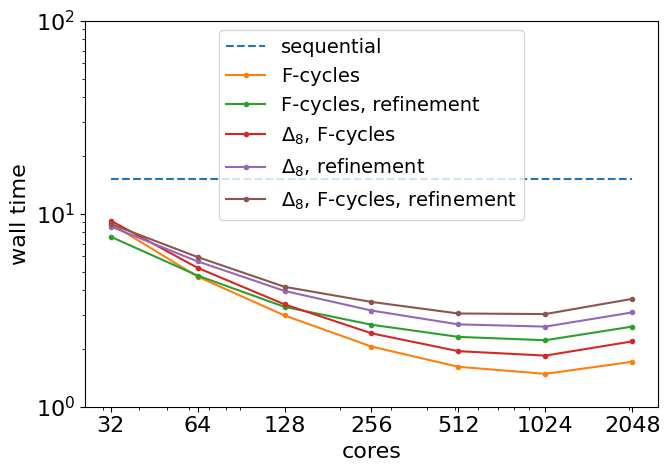

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
ax.loglog(ncores, serial*np.ones(len(ncores)), '--', label="sequential")
ax.loglog(ncores, thetaf, '.-', label=r"F-cycles")
ax.loglog(ncores, thetarf, '.-', label=r"F-cycles, refinement")
ax.loglog(ncores, deltaf, '.-', label=fr"$\Delta_{{{rank}}}$, F-cycles")
ax.loglog(ncores, deltar, '.-', label=fr"$\Delta_{{{rank}}}$, refinement")
ax.loglog(ncores, deltarf, '.-', label=fr"$\Delta_{{{rank}}}$, F-cycles, refinement")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time")
ax.legend(fontsize=14)
plt.xticks(ncores, ncores)
plt.ylim((1e0, 1e2))
plt.tight_layout()
plt.savefig("strong_scaling_KS_tf4_fmg.png", dpi=300)

In [30]:
serial/thetaf

array([ 1.706,  3.209,  5.1  ,  7.389,  9.409, 10.235,  8.858])

In [31]:
serial/deltaf

array([1.645, 2.891, 4.468, 6.312, 7.808, 8.233, 6.949])

In [32]:
serial/deltarf

array([1.712, 2.542, 3.624, 4.34 , 4.983, 5.016, 4.185])

In [33]:
speedups = []
for rank in ranks:
    speedups.append(serial/parseTol(f"ks_Delta{rank}_nc512", tol))
speedups

FileNotFoundError: [Errno 2] No such file or directory: 'ks_Delta4_nc512'

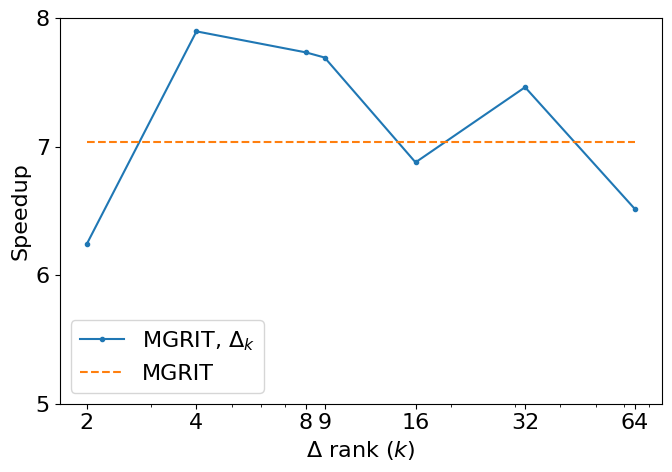

In [ ]:
speedup_th = serial/thetas[-2]
plt.figure(figsize=(7,5))
plt.semilogx(ranks, speedups, '.-', label=r"MGRIT, $\Delta_k$")
plt.semilogx((ranks[0], ranks[-1]), (speedup_th, speedup_th), '--', label="MGRIT")
plt.xticks(ranks, ranks)
plt.yticks(range(5,9), range(5,9))
plt.xlabel(r"$\Delta$ rank ($k$)")
plt.ylabel("Speedup")
plt.legend()
plt.tight_layout()
plt.savefig("compare_ranks.png", dpi=600)
plt.show()